# Case Study

In [288]:
import pandas as pd
import numpy as np


In [289]:
#Help funcs for colored output
from termcolor import colored, cprint
def green(txt):
    return colored(txt, 'green')
def red(txt):
    return colored(txt, 'red')
def blue(txt):
    return colored(txt, 'blue')
def bold(txt):
    return colored(txt, attrs=['bold'])

In [290]:
#Get raw Data
df = pd.read_csv("data/house_data_training.csv", sep=';') 

# Unnamed Spalte entfernen
df = df.iloc[:, 1:]

#Transform string to datetime
df["date"] = pd.to_datetime(df["date"])
df.tail()

#Drop rows with NaN values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14997 entries, 0 to 14999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             14997 non-null  int64         
 1   date           14997 non-null  datetime64[ns]
 2   price          14997 non-null  float64       
 3   bedrooms       14997 non-null  int64         
 4   bathrooms      14997 non-null  float64       
 5   sqft_living    14997 non-null  int64         
 6   sqft_lot       14997 non-null  int64         
 7   floors         14997 non-null  float64       
 8   waterfront     14997 non-null  float64       
 9   dis_super      14997 non-null  float64       
 10  view           14997 non-null  float64       
 11  condition      14997 non-null  float64       
 12  grade          14997 non-null  float64       
 13  sqft_above     14997 non-null  float64       
 14  sqft_basement  14997 non-null  float64       
 15  yr_built       1499

## Modeling

### A) Basic Regression Model

In [291]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def reg_train_test(X_train, X_test, y_train, y_test):
    '''Function for building Basic Regression Model'''

    # fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # evaluate the model
    ypred = model.predict(X_test)
    
    # evaluate predictions
    mae = mean_absolute_error(y_test, ypred)
    print(f'{bold("Mean Absolute Error")}: {blue(np.round(mae))}\n')
    
    print(f'{bold("Regression coefficients:")} \n{blue(model.coef_)}\n')
    
    print(bold("Prediction Examples:"))
    for i in range(0, 5):
        y_pre= ypred[i]
        print(f'{blue(i)} Actual y: {blue(y_test[i])} Predicted y: {blue(np.round(y_pre))}')
 
    return model

In [292]:
from sklearn.model_selection import train_test_split

# Label (y) bestimmen (Price) 
# Daten in Variable x schreiben 
X, y = df, df["price"]

# Spalte "Price" aus den Daten droppen
X = X.drop(columns=["price"])

# Spalte "date" von datetime in ein int umwandeln
#x[["date"]] = x[["date"]].apply(pd.date) !!!
X[["date"]] = X[["date"]].apply(pd.to_numeric)

# Dataframes in numpy-Arrays konvertieren
X,y  = np.array(X.values.tolist()), np.array(y.values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
model = reg_train_test(X_train, X_test, y_train, y_test)

Mean Absolute Error: 6328488.0

Regression coefficients: 
[-5.95470171e-05  1.61604290e-12 -1.60811934e+02  1.17008686e+03
 -7.14346768e+01 -6.89727039e+00  9.52661243e+02 -9.78374309e+00
  1.92017246e+02 -2.22214913e+02 -1.21956412e+03  1.05315362e+03
  1.69078816e+02 -4.46440642e+02  1.27618311e+05  6.76627015e+02
  1.92608098e+04 -4.86604442e+01  9.32572756e+01  1.26394714e+02
 -1.19176578e+01  4.31674363e+03 -9.02128076e+01  4.22653083e+03]

Prediction Examples:
0 Actual y: 210000.0 Predicted y: 1787248.0
1 Actual y: 199500.0 Predicted y: -606569.0
2 Actual y: 252700.0 Predicted y: 3916554.0
3 Actual y: 324500.0 Predicted y: 7495947.0
4 Actual y: 265000.0 Predicted y: 1282062.0


### B) Data Preprocessing

#### data quality issues

In Task 01_Exploration various qualitative problems within the data were identified. In this chapter different approaches are implemented to solve these problems.

##### Outliers

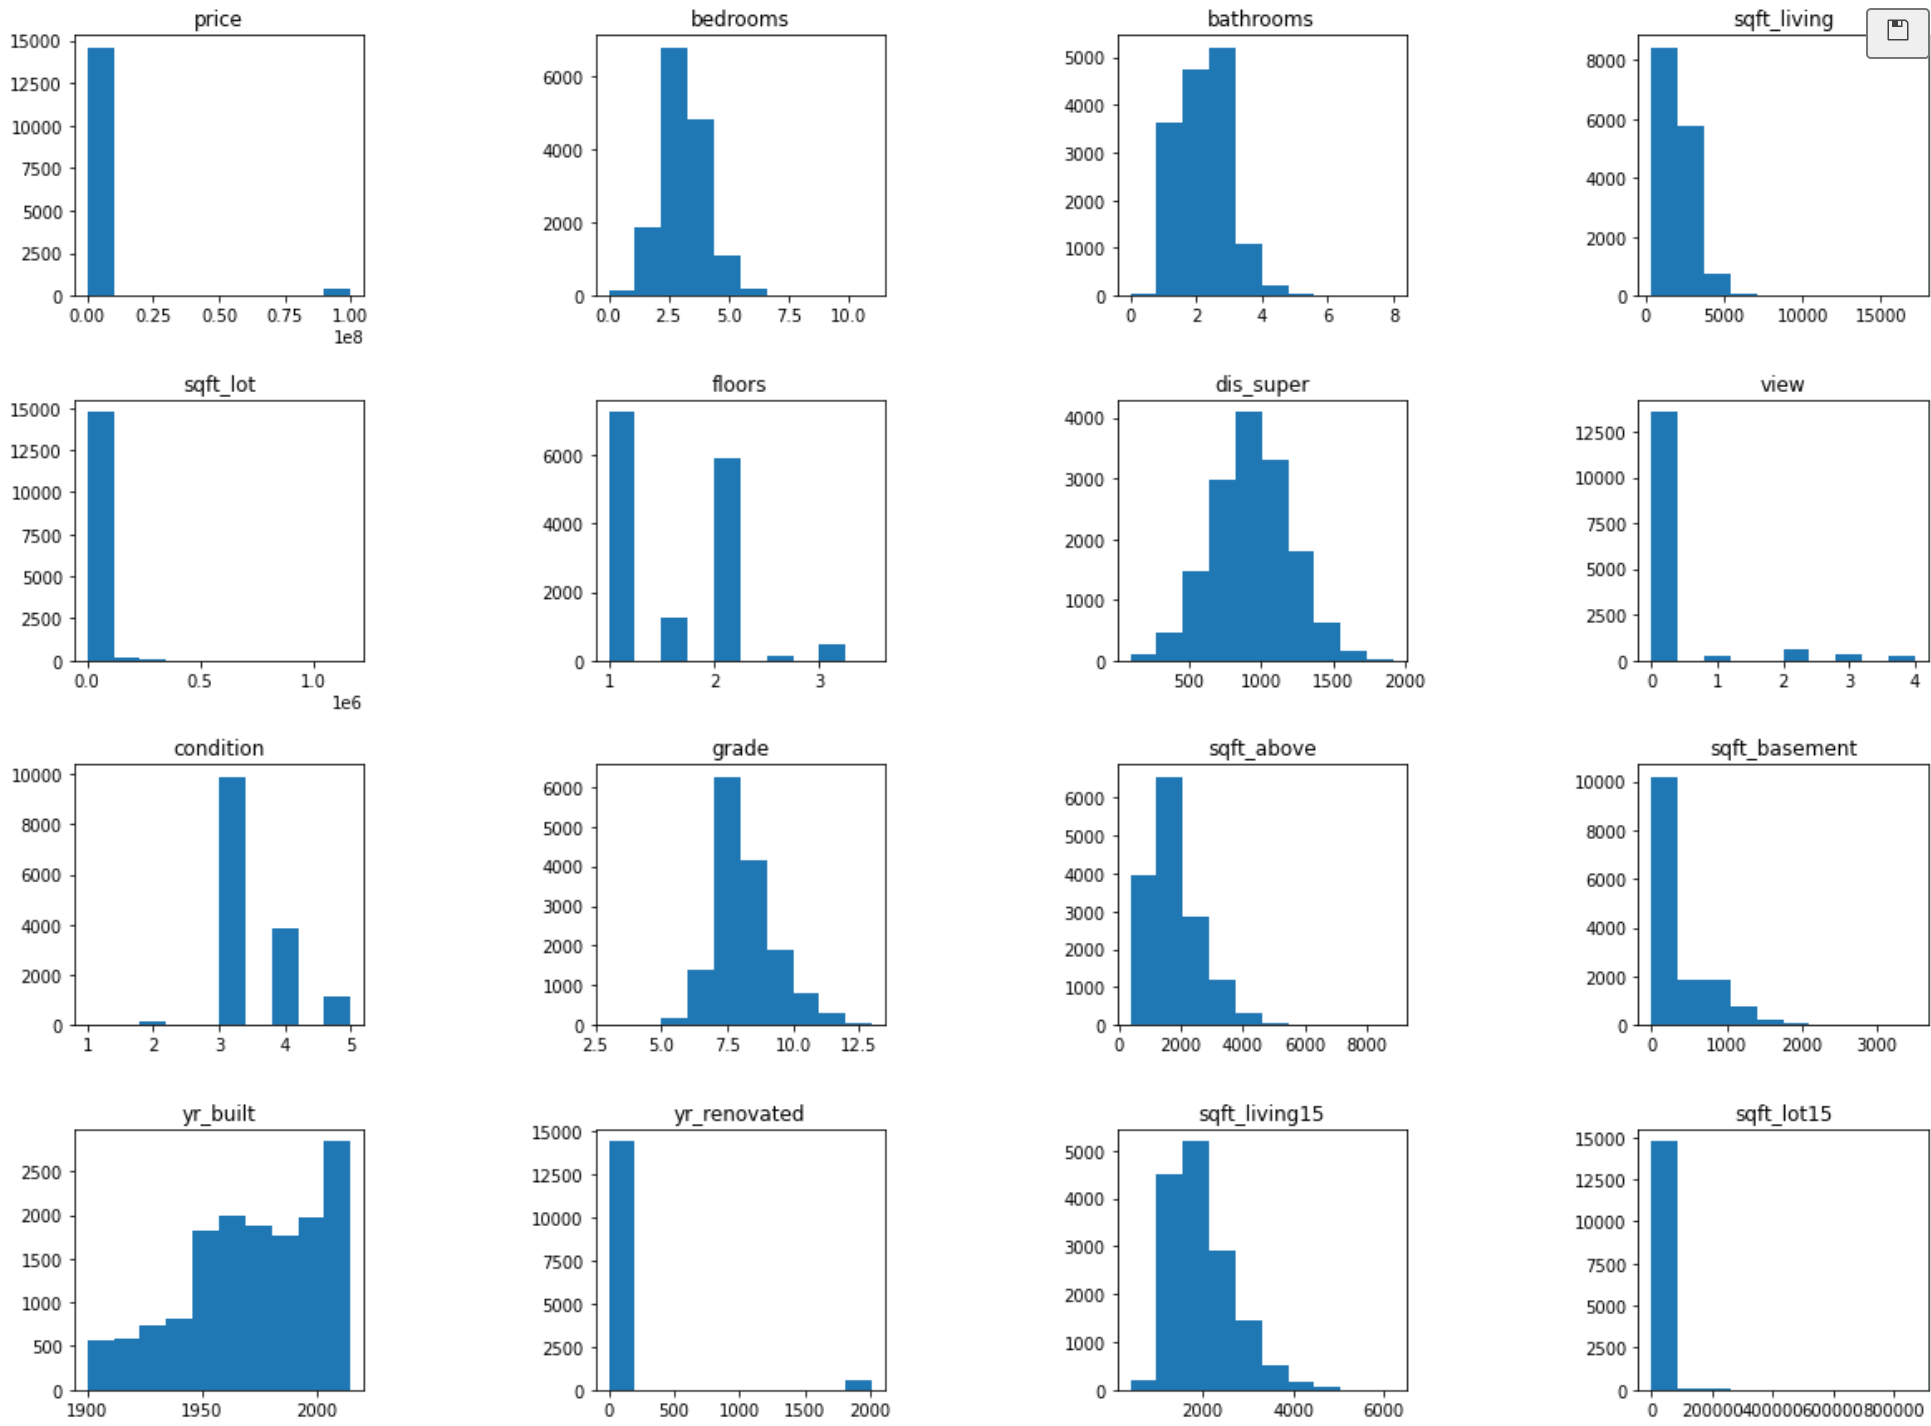

In [293]:
from IPython.display import Image
import os
Image(filename=f'{os.getcwd()}/data/img/outliers_hist.PNG') 

> In this figure we can see the distribution of the values for the different features. Some histograms show a skewed distribution. Sometimes you can immediately recognize Outliers.

Method 1: Univariate outlier detection based on descriptive statistics 

In [297]:
#Univariate outlier detection based on descriptive statistics (three standard deviations)
#can be useful to identify extreme outliers

feature_list = df.columns
outliers_dict = {}
print(bold("Potential Outliers:"))
for feature in feature_list:
    feature_data = df[feature]
    # if feature_data.isnumeric():
 
    three_std=feature_data.std()*3
    mean=feature_data.mean()

    inlier_low=mean-three_std
    inlier_high=mean+three_std
    #print("mean: ",mean, "lower boundary inlier: ",inlier_low, "upper boundary inlier",inlier_high,"\n")

    outlier_list = []
    for i, value in enumerate(feature_data):
        if value < inlier_low or value > inlier_high:
            outlier_list.append(i)

    print(f'{bold(feature)}: {blue(len(outlier_list))} potential outliers detected')
    if not len(outlier_list) == 0:
        outliers_dict[str(feature)]=outlier_list

#store indexes from the original df of every potential outlier existing in a new df for every column
df_outliers = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in outliers_dict.items() ]))
print(df_outliers.tail())
      

Potential Outliers:
id: 0 potential outliers detected
date: 0 potential outliers detected
price: 421 potential outliers detected
bedrooms: 50 potential outliers detected
bathrooms: 120 potential outliers detected
sqft_living: 144 potential outliers detected
sqft_lot: 241 potential outliers detected
floors: 6 potential outliers detected
waterfront: 102 potential outliers detected
dis_super: 40 potential outliers detected
view: 559 potential outliers detected
condition: 23 potential outliers detected
grade: 85 potential outliers detected
sqft_above: 169 potential outliers detected
sqft_basement: 168 potential outliers detected
yr_built: 0 potential outliers detected
yr_renovated: 582 potential outliers detected
zipcode: 0 potential outliers detected
lat: 0 potential outliers detected
long: 163 potential outliers detected
sqft_living15: 171 potential outliers detected
sqft_lot15: 242 potential outliers detected
ahf1: 0 potential outliers detected
ahf2: 37 potential outliers detected
ahf3:

Method 2: Multivariate outlier detection based on distances

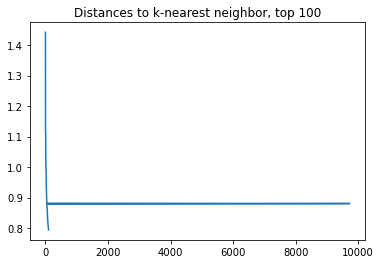

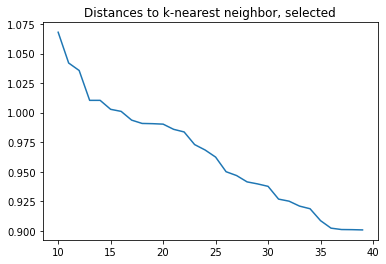

In [295]:
#Multivariate outlier detection based on distances
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

#normalize data to identify outliers
scaler = preprocessing.MinMaxScaler()
X= scaler.fit_transform(X_train)

#determine k nearest neighbors ()
k=3
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

#plot Distances to k-nearest neighbor, top 100
plt.title('Distances to k-nearest neighbor, top 100')
top_distance_min=0
top_distance_max=100
plt.plot(indices[top_distance_min:top_distance_max,0],-np.sort(-distances[:,k])[top_distance_min:top_distance_max])
plt.show()

#plot Distances to k-nearest neighbor, selected
plt.title('Distances to k-nearest neighbor, selected')
top_distance_min=10
top_distance_max=40
plt.plot(indices[top_distance_min:top_distance_max,0],-np.sort(-distances[:,k])[top_distance_min:top_distance_max])
plt.show()

##### Noise

##### Transformed, standardized or normalized

##### Feature Selection

##### Instance Selection

## Modeling Continued

## Evaluation